# Final project

In [1]:
import numpy as np
import pandas as pd
import dask.dataframe as dd
from scipy import stats
import statsmodels.api as sm
#%matplotlib inline
import matplotlib.pyplot as plt
%pylab inline
pylab.rcParams['figure.figsize'] = (18, 9)
import seaborn as sns; sns.set()
from pandas.tseries.offsets import *
from dateutil.relativedelta import *
import datetime as dt
import os
from IPython.core.pylabtools import figsize
from IPython.core.interactiveshell import InteractiveShell

Populating the interactive namespace from numpy and matplotlib


## Step 1-3
1. Choose the factors - size, value, momentum
2. Cast a wide to find ETFs that attempt to implement these factors.
3. Organize a data set on the returns of these ETFs.

In [2]:
# Import and organize factors dataset.
factors = pd.read_csv('factors.csv', parse_dates = ['DATE'])
factors['DATE'] = factors['DATE'] + MonthEnd(0)
factors.set_index('DATE', inplace = True)
factors = factors
factors.head()

,MKTRF,SMB,HML,RMW,CMA,UMD,RF
DATE,,,,,,,
1926-07-31,0.0296,-0.0230,-0.0287,NaN,NaN,NaN,0.0022
1926-08-31,0.0264,-0.0140,0.0419,NaN,NaN,NaN,0.0025
1926-09-30,0.0036,-0.0132,0.0001,NaN,NaN,NaN,0.0023
1926-10-31,-0.0324,0.0004,0.0051,NaN,NaN,NaN,0.0032
1926-11-30,0.0253,-0.0020,-0.0035,NaN,NaN,NaN,0.0031


In [3]:
# Import ETF dataset.
ETF = pd.read_csv('etf_crsp.csv', parse_dates = ['DATE'])
ETF['DATE'] = ETF['DATE'] + MonthEnd(0)

# Extract and organize the returns of each ETFs.
# Drop ETFs that have more than 100 missing values, leaving us 751 ETFs.
ETF_Ret = pd.pivot_table(ETF[['PERMNO','DATE','RET']], columns = ['PERMNO'], index = ['DATE']).dropna(thresh=100, axis=1)
ETF_Ret.columns = ETF_Ret.columns.droplevel().map(str)
ETF_Ret = ETF_Ret
display(ETF_Ret.tail())
print('The number of remaining ETFs:', len(ETF_Ret.columns))

/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


PERMNO,10113,11182,11264,11363,11407,11996,12035,12047,12054,12059,...,93364,93365,93366,93367,93376,93377,93378,93379,93385,93421
DATE,,,,,,,,,,,,,,,,,,,,,
2018-08-31,-0.009271,-0.103638,0.139346,-0.019619,-0.013219,-0.066986,0.010658,0.019084,-0.013036,0.006886,...,0.029124,0.025908,0.089351,0.078630,0.024082,-0.016828,-0.019120,-0.008624,-0.007651,-0.007100
2018-09-30,0.026943,-0.019821,-0.053194,-0.206839,0.026480,0.023892,-0.015668,-0.110861,-0.198519,-0.007574,...,-0.017589,0.047386,-0.031628,-0.036585,-0.001329,-0.017116,-0.023825,-0.011599,-0.001773,-0.000772
2018-10-31,-0.136879,-0.366394,-0.227864,0.007774,-0.081032,-0.014927,-0.080524,-0.071609,-0.023471,0.000268,...,-0.023836,-0.038879,-0.130156,-0.098614,-0.076577,-0.041794,-0.085645,-0.099749,-0.029790,-0.026200
2018-11-30,-0.047404,-0.245441,-0.064780,0.023843,0.036658,0.026869,-0.008014,0.081688,0.071337,0.009254,...,-0.017439,0.009584,0.055364,-0.009811,0.025436,0.123126,-0.040354,0.083799,-0.002147,-0.012921
2018-12-31,-0.093644,-0.483384,-0.327694,0.022096,-0.118873,0.012388,-0.085864,0.012873,0.013103,0.020701,...,-0.132510,-0.118310,-0.165528,-0.101424,-0.103173,0.005963,-0.061148,0.002704,0.015360,0.013541


The number of remaining ETFs: 751


## Step 4 - 5
4. Factor by factor look at how well the ETF’s implement the factors.
5. Come up with a way to rank these ETFs for each factor and explain your thinking behind the ranking.

In [4]:
# Define a multi-factor regression function.
from scipy.stats import chi2
def Time_Series_Regressions(data, factors, data_list, beg, end):
    df = pd.merge(data, factors, left_index = True, right_index = True)
    df = df[beg:end] 
    E = pd.DataFrame(df[data_list].mean()*12, columns = ['AvgReturns'])
    E['Std'] = df[data_list].std()*12**.5
    E['Alpha'] = E['AvgReturns']*np.nan
    E['t_Alpha'] = E['AvgReturns']*np.nan
    E['b_UMD'] = E['AvgReturns']*np.nan
    E['t_UMD'] = E['AvgReturns']*np.nan
    E['b_SMB'] = E['AvgReturns']*np.nan
    E['t_SMB'] = E['AvgReturns']*np.nan
    E['b_HML'] = E['AvgReturns']*np.nan
    E['t_HML'] = E['AvgReturns']*np.nan
    
    T = df.shape[0]
    muF = df[['UMD','SMB','HML']].mean()
    invCovF = np.linalg.inv(df[['UMD','SMB','HML']].cov())
    Resid = pd.DataFrame([], index = df.index, columns = data_list)
    x = sm.add_constant(df[['UMD','SMB','HML']])
    for n in data_list:
        y = df[n]
        res = sm.OLS(y, x, missing='drop').fit()
        E.loc[n,'Alpha'] = res.params[0]*12
        E.loc[n,'b_UMD'] = res.params[1]
        E.loc[n,'b_SMB'] = res.params[2]
        E.loc[n,'b_HML'] = res.params[3]
        E.loc[n,'t_Alpha'] = res.tvalues[0]
        E.loc[n,'t_UMD'] = res.tvalues[1]
        E.loc[n,'t_SMB'] = res.tvalues[2]
        E.loc[n,'t_HML'] = res.tvalues[3]
        E.loc[n,'Tracking Error'] = res.resid.std()
        Resid.loc[:,n] = res.resid # this is for GRS
    E['SR'] = E['AvgReturns']/E['Std']
    E['AR'] = 12**.5*E['t_Alpha']/T**.5  
    # GRS test
    invCov = np.linalg.inv(Resid.cov())
    chi = T*(1+(muF.values @ invCovF @ muF.values.T))**(-1)*(E.Alpha.values @invCov@ E.Alpha.values.T)
    N = Resid.shape[1]   
    return E, [chi,(1-chi2.cdf(chi,N))*100]

In [5]:
# Run regressions for the 751 ETFs.
RESULTS, GRS = Time_Series_Regressions(ETF_Ret, factors, ETF_Ret.columns, '1993', '2018')
RESULTS.tail()

/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


,AvgReturns,Std,Alpha,t_Alpha,b_UMD,t_UMD,b_SMB,t_SMB,b_HML,t_HML,Tracking Error,SR,AR
93377,0.053392,0.228188,0.052000,0.658348,-0.187172,-0.756557,0.189776,0.662782,-0.374596,-1.120794,0.065301,0.233983,0.129320
93378,0.105882,0.181267,0.120070,2.007073,-0.351455,-1.875636,0.608700,2.806790,-0.115192,-0.455055,0.049458,0.584122,0.394252
93379,0.048736,0.261837,0.070038,0.799275,-0.763782,-2.782821,0.301906,0.950417,-0.365290,-0.985179,0.072444,0.186132,0.157003
93385,0.026049,0.089973,0.032596,1.089121,-0.297129,-3.169641,0.010196,0.093980,-0.182793,-1.443396,0.024743,0.289517,0.213937
93421,0.028992,0.090566,0.038098,1.260031,-0.304978,-3.157021,0.047932,0.438043,-0.181674,-1.374975,0.024875,0.320116,0.247509


### 1) Alpha of ETFs

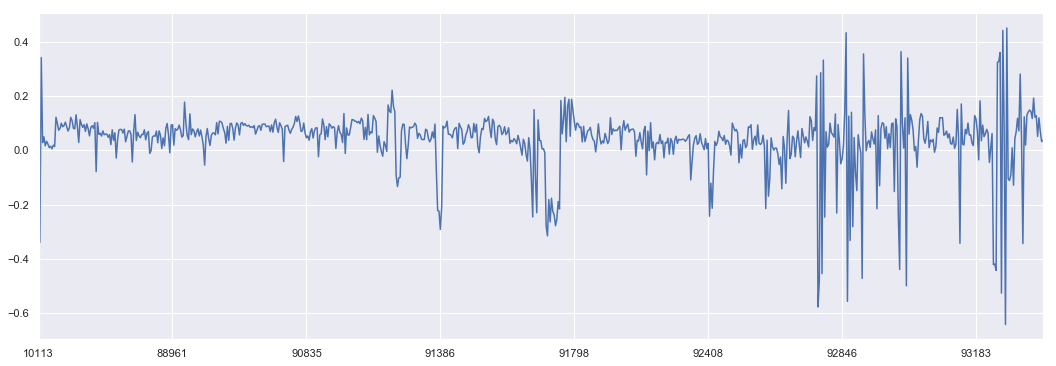

In [6]:
RESULTS['Alpha'].plot(figsize = (18,6))

From this graph, we can see that the alphas of most of the ETFs range from -0.1 to 0.2.

### 2) Beta of ETFs (how well ETFs span exposure to the factor)

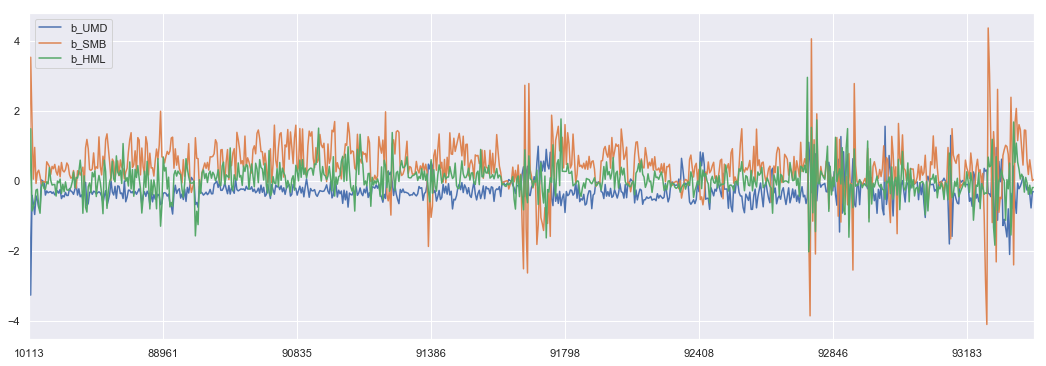

In [7]:
RESULTS[['b_UMD', 'b_SMB', 'b_HML']].plot(figsize = (18,6))

***<center>Exposure to momentum factor***

,AvgReturns,Std,Alpha,t_Alpha,b_UMD,t_UMD,b_SMB,t_SMB,b_HML,t_HML,Tracking Error,SR,AR
92955,-0.109052,0.601582,-0.151880,-0.807143,1.564587,2.774172,-0.007129,-0.010699,-0.520077,-0.689270,0.164768,-0.181275,-0.158548
93157,-0.301071,0.601329,-0.342991,-1.754900,1.302847,2.213430,-1.646325,-2.319775,0.417395,0.520931,0.165636,-0.500676,-0.344717
92858,-0.377688,0.569660,-0.332347,-1.996199,1.272013,3.914252,-1.168023,-1.986726,-0.081450,-0.141780,0.149196,-0.663007,-0.392116
92813,-0.596365,0.545113,-0.578176,-4.266188,1.108415,4.197558,-1.456855,-3.061485,-2.013652,-4.300653,0.121809,-1.094022,-0.838012
91776,-0.295148,0.438638,-0.315441,-2.896687,0.995851,4.647516,-1.246635,-3.144551,-0.665793,-1.742923,0.106549,-0.672873,-0.569000
93283,-0.619886,0.539643,-0.642679,-3.717308,0.958305,1.781533,-2.303179,-3.717290,0.698192,0.967472,0.144288,-1.148696,-0.730195
91782,-0.231544,0.416427,-0.277993,-3.017465,0.907346,5.005244,-0.856795,-2.554594,-1.618866,-5.009286,0.090141,-0.556026,-0.592724
92860,-0.295930,0.477504,-0.281860,-2.009100,0.839097,3.064261,-0.645799,-1.303589,-0.829188,-1.712890,0.125719,-0.619744,-0.394650
92409,-0.260329,0.480188,-0.243037,-1.731653,0.832338,3.094574,-0.526585,-1.049004,0.544796,1.133104,0.132922,-0.542139,-0.340151
91786,-0.219735,0.435783,-0.216096,-1.876916,0.825759,3.644974,-1.575438,-3.758677,0.097321,0.240969,0.112651,-0.504230,-0.368685


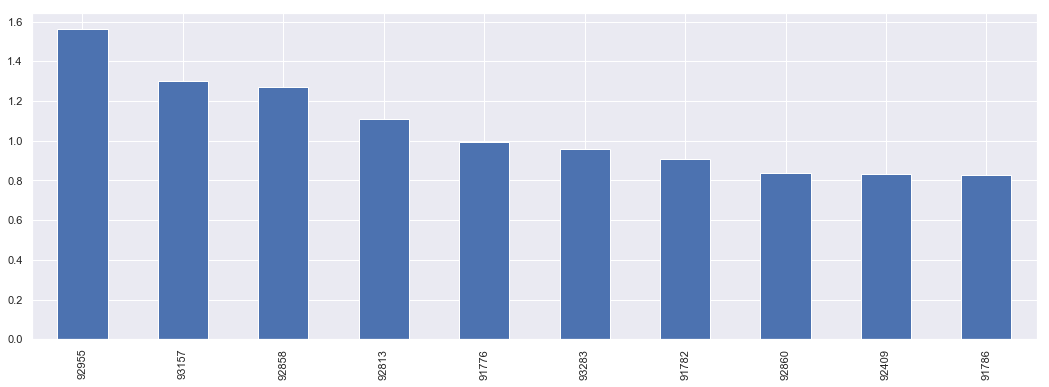

In [8]:
# Choose the top 10 ETFs that have the highest exposure to the momentum factor.
# Vefify their strategies and comfirm that they implement the momentum factor well. 
top_UMD = RESULTS.nlargest(10, 'b_UMD')
top_UMD['b_UMD'].plot.bar(figsize = (18,6));
top_UMD

***<center>Exposure to size factor***

,AvgReturns,Std,Alpha,t_Alpha,b_UMD,t_UMD,b_SMB,t_SMB,b_HML,t_HML,Tracking Error,SR,AR
93258,0.299755,0.517365,0.325567,2.569904,-0.347553,-0.890019,4.368006,9.593399,0.685478,1.306619,0.106174,0.579389,0.504809
92816,0.326449,0.549419,0.287026,2.357394,-0.327302,-1.379669,4.058837,9.493991,1.532497,3.643185,0.109433,0.594171,0.463066
11182,-0.515189,0.855012,-0.339677,-1.382338,-3.250613,-4.150685,3.533757,3.990633,1.494742,1.397590,0.201258,-0.602551,-0.271534
93259,0.306292,0.449398,0.328205,2.583427,-0.366479,-0.935841,3.074015,6.732394,0.408408,0.776290,0.106474,0.681561,0.507466
92881,0.395330,0.473414,0.356087,2.990421,-0.645329,-2.709029,2.782963,6.621934,0.918896,2.012906,0.106529,0.835061,0.587412
91722,0.112473,0.386636,0.112882,1.373512,-0.401491,-2.475174,2.782896,9.279373,0.720717,2.491885,0.080686,0.290901,0.269801
91719,0.144848,0.385112,0.150514,1.901003,-0.443124,-2.835658,2.734305,9.463838,0.893335,3.206098,0.077732,0.376120,0.373416
93284,0.426055,0.610015,0.452081,2.317045,-1.115600,-1.837733,2.617815,3.743878,-0.831746,-1.021265,0.162835,0.698435,0.455140
93341,0.297221,0.425465,0.281753,2.194959,-0.346269,-0.859355,2.392053,5.119132,-1.536881,-2.837169,0.106586,0.698579,0.431158
93360,-0.058282,0.352275,0.019763,0.210382,-0.918314,-3.114252,2.074259,6.065853,1.085333,2.737860,0.078000,-0.165444,0.041326


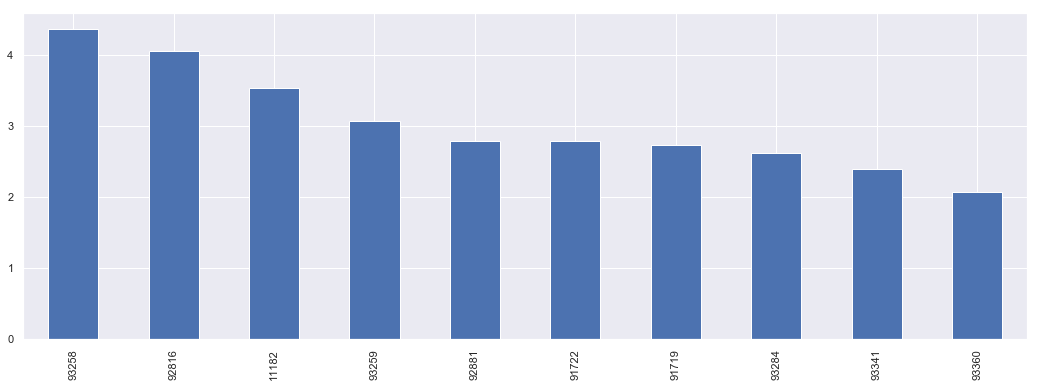

In [9]:
# Choose the top 10 ETFs that have the highest exposure to the size factor.
# Vefify their strategies and comfirm that they implement the size factor well. 
top_SMB = RESULTS.nlargest(10, 'b_SMB')
top_SMB['b_SMB'].plot.bar(figsize = (18,6));
top_SMB

***<center>Exposure to value factor***

,AvgReturns,Std,Alpha,t_Alpha,b_UMD,t_UMD,b_SMB,t_SMB,b_HML,t_HML,Tracking Error,SR,AR
92812,0.252220,0.557653,0.275094,1.940536,-0.448584,-1.624049,1.291708,2.595021,2.959985,6.043666,0.127414,0.452288,0.381182
91795,0.004916,0.423639,0.052261,0.534127,-0.698818,-3.629698,0.942655,2.646376,1.773818,5.168063,0.095734,0.011605,0.104919
92820,0.081577,0.599856,0.069084,0.407542,-0.563493,-1.706063,1.919870,3.225521,1.745499,2.980451,0.152358,0.135995,0.080054
93343,-0.360286,0.432713,-0.343728,-2.636341,0.431787,1.055011,-2.388170,-5.031751,1.686475,3.065161,0.108260,-0.832622,-0.517860
92816,0.326449,0.549419,0.287026,2.357394,-0.327302,-1.379669,4.058837,9.493991,1.532497,3.643185,0.109433,0.594171,0.463066
91005,0.031494,0.255352,0.049973,0.993780,-0.344689,-3.355505,0.625540,3.425959,1.512604,8.376431,0.051915,0.123336,0.195209
92864,-0.204347,0.575964,-0.148618,-0.829800,0.758259,2.169027,-0.675021,-1.067319,1.498469,2.424701,0.160497,-0.354792,-0.162999
11182,-0.515189,0.855012,-0.339677,-1.382338,-3.250613,-4.150685,3.533757,3.990633,1.494742,1.397590,0.201258,-0.602551,-0.271534
91315,0.048422,0.235798,0.072030,1.486877,-0.035523,-0.364645,1.066336,5.995504,1.386562,8.072415,0.048803,0.205352,0.292069
91222,0.032541,0.224416,0.057523,1.231858,-0.193897,-2.059349,0.625219,3.634298,1.335435,8.046764,0.047215,0.145004,0.241975


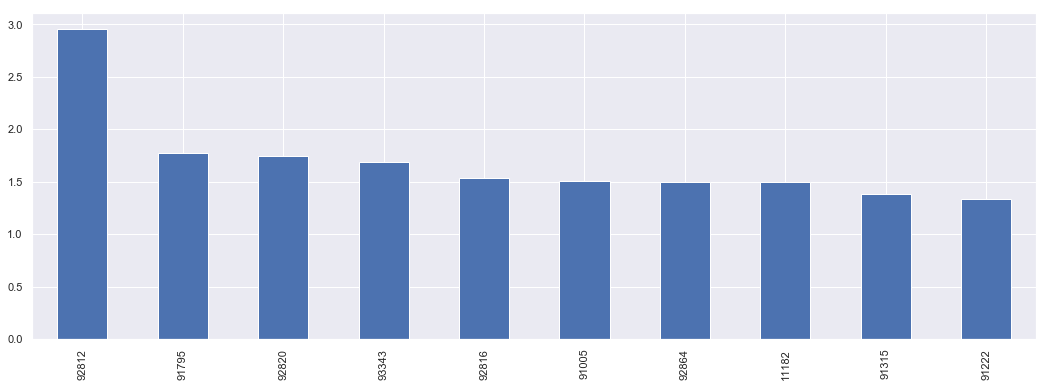

In [10]:
# Choose the top 10 ETFs that have the highest exposure to the value factor.
# Vefify their strategies and comfirm that they implement the value factor well. 
top_HML = RESULTS.nlargest(10, 'b_HML')
top_HML['b_HML'].plot.bar(figsize = (18,6));
top_HML

### 3) Tracking error of ETFs

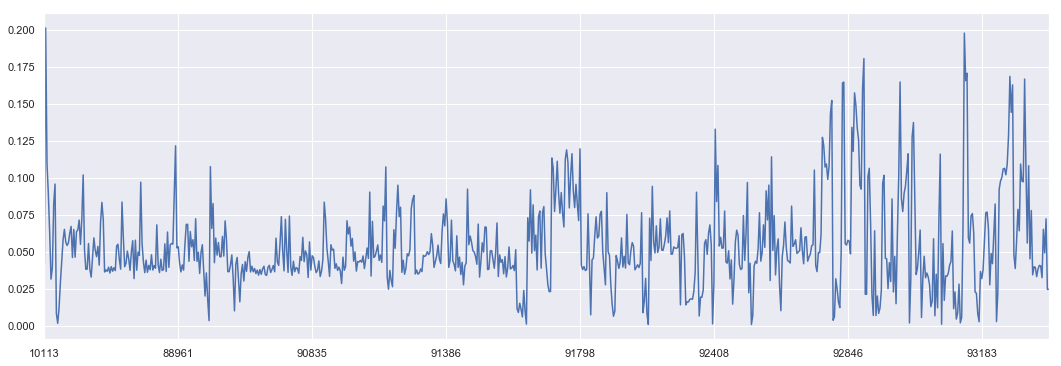

In [11]:
RESULTS['Tracking Error'].plot(figsize = (18,6))

From this graph, we can see that the tracking errors of most of the ETFs range from 0.025 to 0.1, meaning that most of the ETFs tightly bound the return to the benchmark return.

### 4) Per unit exposure of ETFs (how cheaply ETFs implement the strategy)

In this part, we calculate the per unit exposure of ETFs using expense ratios divided by betas. The number measures how much investors need to pay for one unit of exposure. The smaller the number is, the less investors need to pay.

***<center>Per unit exposure to momentum factor***

In [12]:
# Collect the expense ratios of the top 10 ETFs.
# Calculate their unit exposure to the momentum factor.
# Select top 3 ETFs that have the smallest unit exposure to the momentum factor.
exp_UMD = [0.0095, 0.0095, 0.0109, 0.0107, 0.0095, 0.0108, 0.0095, 0.0108, 0.0095, 0.0095]
top_UMD['Exp'] = np.array(exp_UMD)
top_UMD['Unit Exposure'] = top_UMD['Exp']/top_UMD['b_UMD']
top3_UMD = top_UMD.nsmallest(3, 'Unit Exposure')
top3_UMD

,AvgReturns,Std,Alpha,t_Alpha,b_UMD,t_UMD,b_SMB,t_SMB,b_HML,t_HML,Tracking Error,SR,AR,Exp,Unit Exposure
92955,-0.109052,0.601582,-0.151880,-0.807143,1.564587,2.774172,-0.007129,-0.010699,-0.520077,-0.689270,0.164768,-0.181275,-0.158548,0.0095,0.006072
93157,-0.301071,0.601329,-0.342991,-1.754900,1.302847,2.213430,-1.646325,-2.319775,0.417395,0.520931,0.165636,-0.500676,-0.344717,0.0095,0.007292
92858,-0.377688,0.569660,-0.332347,-1.996199,1.272013,3.914252,-1.168023,-1.986726,-0.081450,-0.141780,0.149196,-0.663007,-0.392116,0.0109,0.008569


***<center>Per unit exposure to size factor***

In [13]:
# Collect the expense ratios of the top 10 ETFs.
# Calculate their unit exposure to the size factor.
# Select top 3 ETFs that have the smallest unit exposure to the size factor.
exp_SMB = [0.0095, 0.0114, 0.0095, 0.0095, 0.0095, 0.0095, 0.0095, 0.0029, 0.0099, 0.0099]
top_SMB['Exp'] = np.array(exp_SMB)
top_SMB['Unit Exposure'] = top_SMB['Exp']/top_SMB['b_SMB']
top3_SMB = top_SMB.nsmallest(3, 'Unit Exposure')
top3_SMB

,AvgReturns,Std,Alpha,t_Alpha,b_UMD,t_UMD,b_SMB,t_SMB,b_HML,t_HML,Tracking Error,SR,AR,Exp,Unit Exposure
93284,0.426055,0.610015,0.452081,2.317045,-1.115600,-1.837733,2.617815,3.743878,-0.831746,-1.021265,0.162835,0.698435,0.455140,0.0029,0.001108
93258,0.299755,0.517365,0.325567,2.569904,-0.347553,-0.890019,4.368006,9.593399,0.685478,1.306619,0.106174,0.579389,0.504809,0.0095,0.002175
11182,-0.515189,0.855012,-0.339677,-1.382338,-3.250613,-4.150685,3.533757,3.990633,1.494742,1.397590,0.201258,-0.602551,-0.271534,0.0095,0.002688


***<center>Per unit exposure to value factor***

In [14]:
# Collect the expense ratios of the top 10 ETFs.
# Calculate their unit exposure to the value factor.
# Select top 3 ETFs that have the smallest unit exposure to the value factor.
exp_HML = [0.0095, 0.0100, 0.0109, 0.0095, 0.0095, 0.0095, 0.0133, 0.0114, 0.0035, 0.0029]
top_HML['Exp'] = np.array(exp_HML)
top_HML['Unit Exposure'] = top_HML['Exp']/top_HML['b_HML']
top3_HML = top_HML.nsmallest(3, 'Unit Exposure')
top3_HML

,AvgReturns,Std,Alpha,t_Alpha,b_UMD,t_UMD,b_SMB,t_SMB,b_HML,t_HML,Tracking Error,SR,AR,Exp,Unit Exposure
91222,0.032541,0.224416,0.057523,1.231858,-0.193897,-2.059349,0.625219,3.634298,1.335435,8.046764,0.047215,0.145004,0.241975,0.0029,0.002172
91315,0.048422,0.235798,0.072030,1.486877,-0.035523,-0.364645,1.066336,5.995504,1.386562,8.072415,0.048803,0.205352,0.292069,0.0035,0.002524
92812,0.252220,0.557653,0.275094,1.940536,-0.448584,-1.624049,1.291708,2.595021,2.959985,6.043666,0.127414,0.452288,0.381182,0.0095,0.003209


**How to rank the ETFs:**
* First, we want to choose the ETFs that well implement each factor, so we select the top 10 ETFs that have the highest exposure (beta) to each of the factor, and we get a total of 30 ETFs.
* Second, we want to find the cheapest way with good exposure to these factors, so we collect the expense ratios of the 30 ETFs and calculate their unit exposure to each factor (expense ratio/beta). We want the per unit exposure to be small, so we pick top 3 ETFs that have the smallest unit exposure to each of the factor, which left us a total of 9 ETFs.
* In below, we will use these 9 ETFs to construct the optimal portfolio.

## Step 6
6. Once you have the top ranked ETF for each of your factors, explain how to construct the optimal portfolio among these ETFs.

In [15]:
# Define a function to organize the excess returns of selected ETFs.
def rf_ret(data):
    ret = []
    for n in list(range(len(data))):
        ret.append(ETF_Ret[data.index[n]])
    array_data = np.column_stack(ret)
    df_ret = pd.DataFrame(data = array_data, index = ETF_Ret.index, columns = data.index)
    df_ret['RF'] = factors.iloc[(len(factors)-311):,-1]
    rf_ret = (df_ret.drop('RF',axis=1)).subtract(df_ret['RF'],axis="index")
    return rf_ret

# Define a function to calculate the weight of each ETF or factor using three methods: MVE, MV and EW.
def weight(data):
    rf_ret_cov = data.cov()
    rf_ret_mean = data.mean()
    rf_ret_cov_ide = np.diag(np.diag(rf_ret_cov))/np.diag(rf_ret_cov)
    MVE = np.linalg.inv(rf_ret_cov) @ rf_ret_mean.values
    MV = np.linalg.inv(rf_ret_cov) @ (rf_ret_mean.values*0 + rf_ret_mean.mean())
    EW = np.linalg.inv(rf_ret_cov_ide) @ np.ones(len(rf_ret_cov))*0.05
    
    W = pd.DataFrame({"MVE": np.array(MVE/MVE.sum()),
                      "MV": np.array(MV/MV.sum()),
                      "EW": np.array(EW/EW.sum()),}, index = rf_ret_cov.columns)
    return W

### 1) Weights of ETFs within each factor

,MVE,MV,EW
92955,-1.249046,0.359826,0.333333
93157,-0.033722,0.329987,0.333333
92858,2.282768,0.310188,0.333333


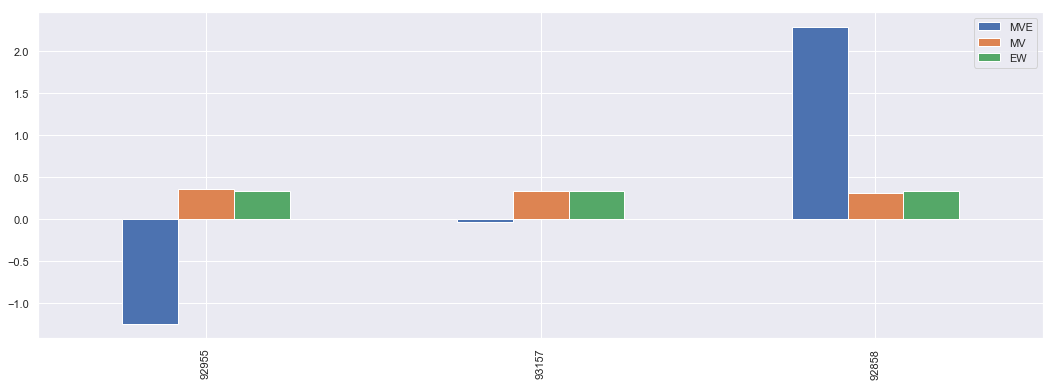

In [16]:
# Calculate the weight of each ETF in the momentum factor using three methods.
rf_UMD = rf_ret(top3_UMD)
W_UMD = weight(rf_UMD)
W_UMD.plot.bar(figsize = (18,6));
W_UMD

,MVE,MV,EW
93284,0.796316,0.192069,0.333333
93258,1.628728,0.758386,0.333333
11182,-1.425043,0.049546,0.333333


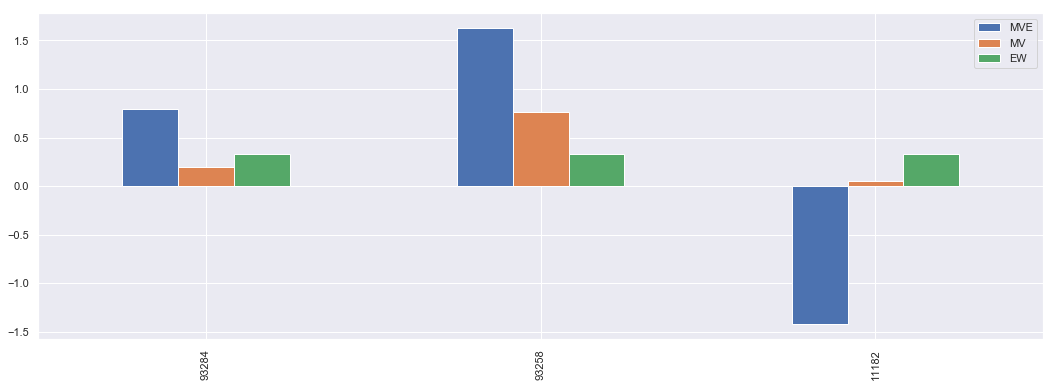

In [17]:
# Calculate the weight of each ETF in the size factor using three methods.
rf_SMB = rf_ret(top3_SMB)
W_SMB = weight(rf_SMB)
W_SMB.plot.bar(figsize = (18,6));
W_SMB

,MVE,MV,EW
91222,2.923644,1.393741,0.333333
91315,-0.945994,0.032932,0.333333
92812,-0.977650,-0.426672,0.333333


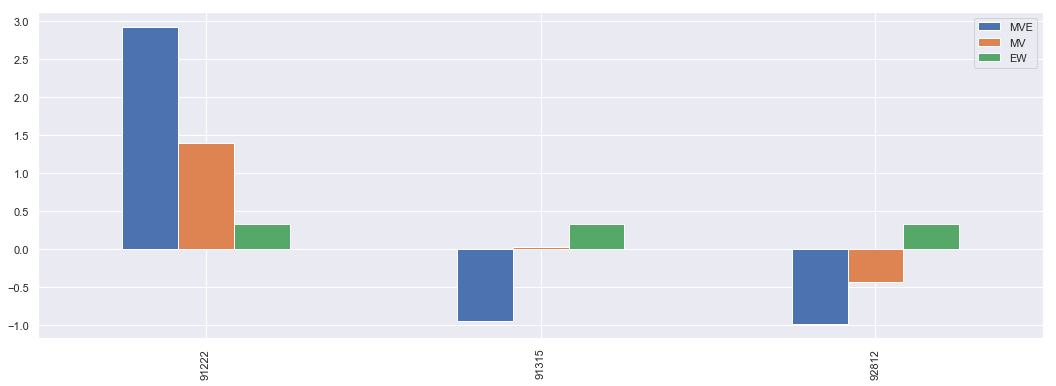

In [18]:
# Calculate the weight of each ETF in the value factor using three methods.
rf_HML = rf_ret(top3_HML)
W_HML = weight(rf_HML)
W_HML.plot.bar(figsize = (18,6));
W_HML

### 2) Weights of three factors

In [19]:
# Define a function to calculate the monthly excess returns of factor portfolios.
def df_port(r, w):
    port = []
    for n in list(range(3)):
        port.append(r @ w.iloc[:, n].T)
    array_port = np.column_stack(port)
    df_port = pd.DataFrame(data = array_port, index = r.index, columns = w.columns)
    return df_port

In [20]:
# Get the monthly excess returns of three factor portfolios with three weighting methods.
port_UMD = df_port(rf_UMD, W_UMD)
port_SMB = df_port(rf_SMB, W_SMB)
port_HML = df_port(rf_HML, W_HML)
port_UMD.columns = [str(col) + '_UMD' for col in port_UMD.columns]
port_SMB.columns = [str(col) + '_SMB' for col in port_SMB.columns]
port_HML.columns = [str(col) + '_HML' for col in port_HML.columns]

In [21]:
# Calculate the weight of factor portfolios using MVE method.
port_MVE = port_UMD.iloc[:, [0]].join(port_SMB.iloc[:, [0]]).join(port_HML.iloc[:, [0]])
W_MVE = weight(port_MVE)
W_MVE

,MVE,MV,EW
MVE_UMD,-0.245284,-0.040969,0.333333
MVE_SMB,0.708739,0.084615,0.333333
MVE_HML,0.536545,0.956354,0.333333


In [22]:
# Calculate the weight of factor portfolios using MV method.
port_MV = port_UMD.iloc[:, [1]].join(port_SMB.iloc[:, [1]]).join(port_HML.iloc[:, [1]])
W_MV = weight(port_MV)
W_MV

,MVE,MV,EW
MV_UMD,0.092388,0.073159,0.333333
MV_SMB,1.608116,0.045753,0.333333
MV_HML,-0.700504,0.881088,0.333333


In [23]:
# Calculate the weight of factor portfolios using EW method.
port_EW = port_UMD.iloc[:, [2]].join(port_SMB.iloc[:, [2]]).join(port_HML.iloc[:, [2]])
W_EW = weight(port_EW)
W_EW

,MVE,MV,EW
EW_UMD,-2.557375,0.378849,0.333333
EW_SMB,-3.080994,0.178925,0.333333
EW_HML,6.638369,0.442226,0.333333


In [24]:
# Get the monthly excess returns of the final portfolio with 9 different combinations of weighting methods.
MVE = df_port(port_MVE, W_MVE)
MV = df_port(port_MV, W_MV)
EW = df_port(port_EW, W_EW)
MVE.columns = ['MVE_' + str(col) for col in MVE.columns]
MV.columns = ['MV_' + str(col) for col in MV.columns]
EW.columns = ['EW_' + str(col) for col in EW.columns]
Total = MVE.join(MV).join(EW)

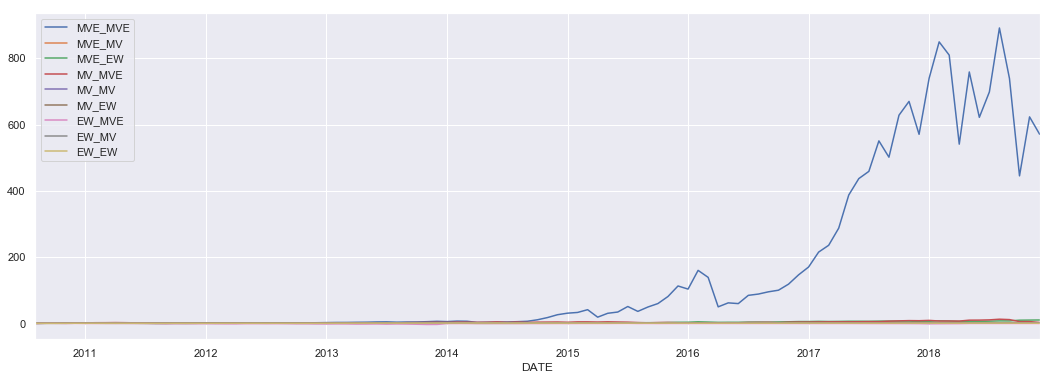

In [25]:
# Calculate the cumulative returns of the 9 portfolios.
((Total+1).iloc[210:, :]).cumprod().plot(figsize=(18,6))

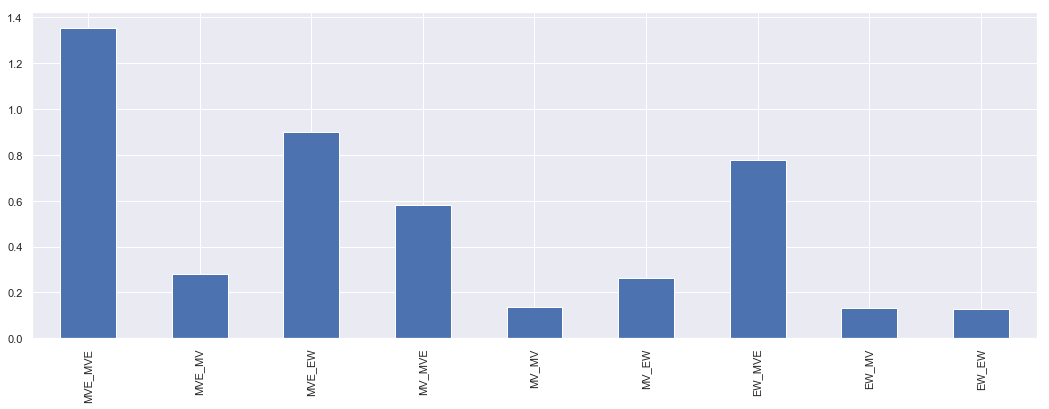

In [26]:
# Calculate the Sharpe ratios of the 9 portfolios.
((Total.mean()/Total.std())*12**0.5).plot.bar(figsize = (18,6));

Weight
Factor ETF            
UMD    92955  0.306371
       93157  0.008272
       92858 -0.559927
SMB    93284  0.564380
       93258  1.154343
       11182 -1.009984
HML    91222  1.568667
       91315 -0.507569
       92812 -0.524554

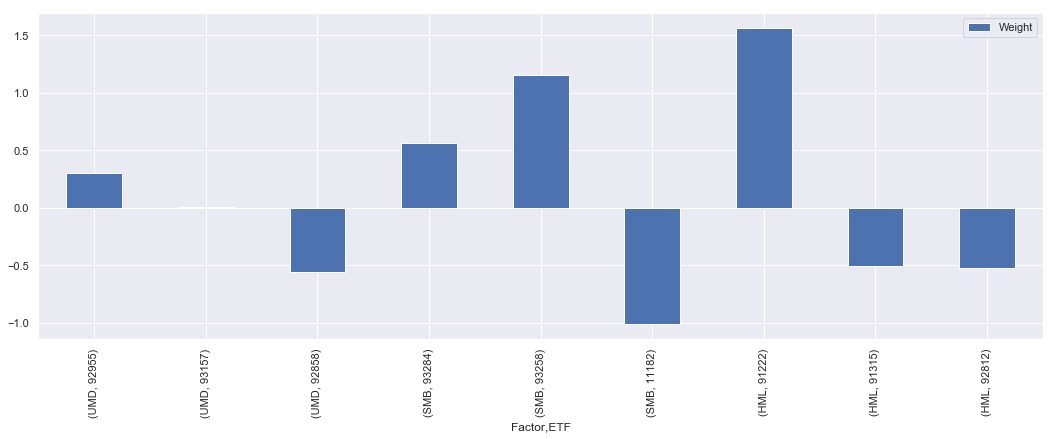

In [27]:
# Calculate the optimal weight of the 9 ETFs.
ETF_UMD = W_UMD.iloc[:,[0]] * W_MVE.iloc[0,0]
ETF_SMB = W_SMB.iloc[:,[0]] * W_MVE.iloc[1,0]
ETF_HML = W_HML.iloc[:,[0]] * W_MVE.iloc[2,0]
optimal_weight = pd.concat([ETF_UMD, ETF_SMB, ETF_HML], keys=['UMD', 'SMB', 'HML'])
optimal_weight.index.names = ['Factor', 'ETF']
optimal_weight.rename(columns = {"MVE": "Weight"}, inplace = True)
optimal_weight.plot.bar(figsize = (18,6));
optimal_weight

**How to construct the optimal portfolio:**
* First, we use 3 ETFs within each factor to construct three factor portfolios based on MVE, MV and EW weighting methods. MVE is to maximize Sharpe ratio of the portfolio, MV is to minimize the variance of the portfolio, and EW simply means a equally weight portfolio.
* Second, we use MVE, MV and EW to weight three factor portfolios, which gives us a total of 9 portfolios using different combinations of weighting methods.
* Then, we calculate the Sharpe ratios of the 9 portfolios. According to the graph above, we can see that the MVE-MVE weighting method gives the highest Sharpe ratio and the best cumulative return, leading us to the optimal portfolio.

# Step 7
7. Discuss how your allocation to the factors would be different if you could trade the factors directly instead of using the ETFs.

In [28]:
# Calculate the weights of the three factors through MVE method. 
factors1 = factors.iloc[:, [1,2,5]]
factors1_cov = factors1.cov()
factors1_mean = factors1.mean()
w_factor = np.linalg.inv(factors1_cov) @ factors1_mean.values
w_factor = w_factor/w_factor.sum()
compare = pd.DataFrame({'Trade based on ETFs': np.array(W_MVE['MVE']),
                        'Trade directly': w_factor}, index = ['UMD', 'SMB', 'HML'])
compare

,Trade based on ETFs,Trade directly
UMD,-0.245284,0.181229
SMB,0.708739,0.433044
HML,0.536545,0.385727


In general, the allocations of the factors when we trade them directly are all different from the allocations of the factors when we trade based on ETFs. 

# Step 8
8. Discuss which factors can be implemented more cheaply using the ETFs.

In [29]:
# Run three regressions on each factor portfolios, and calculate their alpha-to-beta ratios and tracking errors.
x1 = sm.add_constant(factors.iloc[-311:, 5])
y1 = port_MVE.iloc[:, 0]
res1 = sm.OLS(y1, x1, missing='drop').fit()
UMD_list = [res1.params[0]*12/res1.params[1], res1.resid.std()]

x2 = sm.add_constant(factors.iloc[-311:, 1])
y2 = port_MVE.iloc[:, 1]
res2 = sm.OLS(y2, x2, missing='drop').fit()
SMB_list = [res2.params[0]*12/res2.params[1], res2.resid.std()]

x3 = sm.add_constant(factors.iloc[-311:, 2])
y3 = port_MVE.iloc[:, 2]
res3 = sm.OLS(y3, x3, missing='drop').fit()
HML_list = [res3.params[0]*12/res3.params[1], res3.resid.std()]

compare2 = pd.DataFrame({'UMD': np.array(UMD_list),
                         'SMB': np.array(SMB_list),
                         'HML': np.array(HML_list)}, index = [['Alpha-to-beta Ratio', 'Tracking Error']])
compare2

,UMD,SMB,HML
Alpha-to-beta Ratio,6.077752,0.423626,0.221677
Tracking Error,0.215209,0.328349,0.072249


Alpha-to-beta ratio measures the cost of per unit exposure. We can see the alpha-to-beta ratio of momentum factor is almost 12 times higher than the rest 2 factors, so momentum factor is the most expensive one. The alpha-to-beta ratio and tracking error of value factor are the smallest, so we believe that value factor can be well implemented through the cheapest way.